**MENGIMPORT SEMUA LIBRARY YANG DIBUTUHKAN**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# INI TAMBAHAN DARI DENI YANG INGIN MENGGUNAKAN EfficientNetB1
from tensorflow.keras.applications import EfficientNetB1
#import plotly
import plotly.express as px

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, load_img
import zipfile

**MENGIMPORT DATASET DARI KAGGLE**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d imbikramsaha/paddy-doctor

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/paddy-doctor
License(s): CC0-1.0
100% 1.02G/1.02G [00:03<00:00, 316MB/s]
100% 1.02G/1.02G [00:03<00:00, 298MB/s]


**MENGTEKSTRAK DATASET YANG TELAH DI DOWNLOAD**

In [ ]:
#shutil.rmtree('/content/paddy-disease-classification')

In [ ]:
!unzip -q paddy-doctor.zip

In [ ]:
rm paddy-doctor.zip

**MENGHAPUS GAMBAR PENYAKIT YANG TIDAK DI PERLUKAN DARI FOLDER train_images**

In [ ]:
# Daftar nama folder yang ingin dihapus
folders_to_remove = [
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'dead_heart',
    'downy_mildew',
    'hispa'
]

# Iterasi untuk menghapus setiap folder
base_path = '/content/paddy-disease-classification/train_images/'
for folder in folders_to_remove:
    shutil.rmtree(base_path + folder)


In [ ]:
"""
shutil.rmtree('/content/paddy-disease-classification/train_images/bacterial_leaf_streak')
shutil.rmtree('/content/paddy-disease-classification/train_images/bacterial_panicle_blight')
shutil.rmtree('/content/paddy-disease-classification/train_images/dead_heart')
shutil.rmtree('/content/paddy-disease-classification/train_images/downy_mildew')
shutil.rmtree('/content/paddy-disease-classification/train_images/hispa')
"""

**MEMBAGI DATASET UNTUK VALIDASI MODEL**

In [ ]:
dataset_path = "/content/paddy-disease-classification"
train_dir = os.path.join(dataset_path, "train_images")

In [ ]:
import shutil
validation_dir = os.path.join(dataset_path, "validation_images")
os.makedirs(validation_dir, exist_ok=True)

In [ ]:
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(validation_dir, cls)
    os.makedirs(val_cls_path, exist_ok=True)
    images = os.listdir(cls_path)
    np.random.shuffle(images)
    val_count = int(0.2 * len(images)) #0.2 for validation images
    for img in images[:val_count]:
        shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_path, img))

**MELAKUKAN EDA (EKSPLORASI DATA ANALISIS)**

Number of Classes: 5
Name of Classes: ['brown_spot', 'bacterial_leaf_blight', 'normal', 'blast', 'tungro']


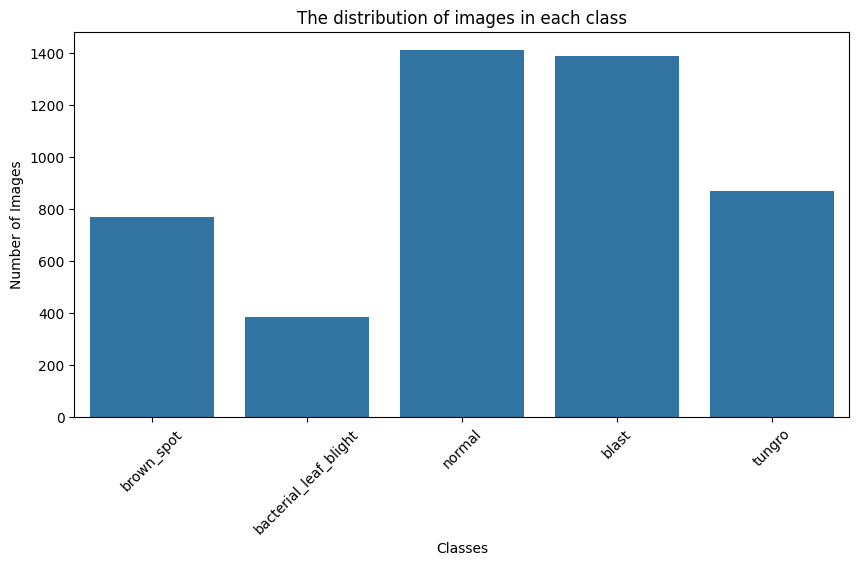

In [ ]:
def perform_eda(train_dir):
    classes = os.listdir(train_dir)
    print(f"Number of Classes: {len(classes)}")
    print(f"Name of Classes: {classes}")

    class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=45)
    plt.title("The distribution of images in each class")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

perform_eda(train_dir)

**MEMVARIASI GAMBAR ATAU AUGMENTASI GAMBAR**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 4830 images belonging to 5 classes.
Found 1204 images belonging to 5 classes.


**PEMBOBOTAN KELAS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_labels)),
    y=np.concatenate([np.full(len(train_generator.filepaths[i]), i) for i in range(len(class_labels))])
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


**PRE TRAIN MODEL**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(229, 229, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 227, 227, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,887,109 (18.64 MB)

 Trainable params: 4,887,109 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 94s 950ms/step - accuracy: 0.2869 - loss: 1.5440 - val_accuracy: 0.3762 - val_loss: 1.4929
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 774ms/step - accuracy: 0.3965 - loss: 1.4461 - val_accuracy: 0.3729 - val_loss: 1.4274
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 767ms/step - accuracy: 0.4345 - loss: 1.3792 - val_accuracy: 0.4809 - val_loss: 1.2596
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 772ms/step - accuracy: 0.4439 - loss: 1.3354 - val_accuracy: 0.4618 - val_loss: 1.2823
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 769ms/step - accuracy: 0.4719 - loss: 1.2873 - val_accuracy: 0.5166 - val_loss: 1.1381


**USING TRANSFER LEARNING (EfficientNetB0)**

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,411,048 (16.83 MB)

 Trainable params: 4,369,025 (16.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=65,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.2078 - loss: 1.7125 - val_accuracy: 0.2924 - val_loss: 1.5774
Epoch 2/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 780ms/step - accuracy: 0.3517 - loss: 1.5194 - val_accuracy: 0.2924 - val_loss: 1.5686
Epoch 3/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 781ms/step - accuracy: 0.4152 - loss: 1.4424 - val_accuracy: 0.2924 - val_loss: 1.5422
Epoch 4/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 775ms/step - accuracy: 0.4803 - loss: 1.3284 - val_accuracy: 0.3198 - val_loss: 1.5354
Epoch 5/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 774ms/step - accuracy: 0.5260 - loss: 1.2735 - val_accuracy: 0.3264 - val_loss: 1.5370
Epoch 6/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 772ms/step - accuracy: 0.5280 - loss: 1.2032 - val_accuracy: 0.2882 - val_loss: 1.5597
Epoch 7/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 778ms/step - accuracy: 0.5689 - loss: 1.0990 - val_accuracy: 0.3065 - val_loss: 1.5754
Epoch 8/65
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 783ms/step - accuracy: 0.6054 - loss: 1.0277 - val_accura

**PLOT FOR ACCURACY AND LOSS**

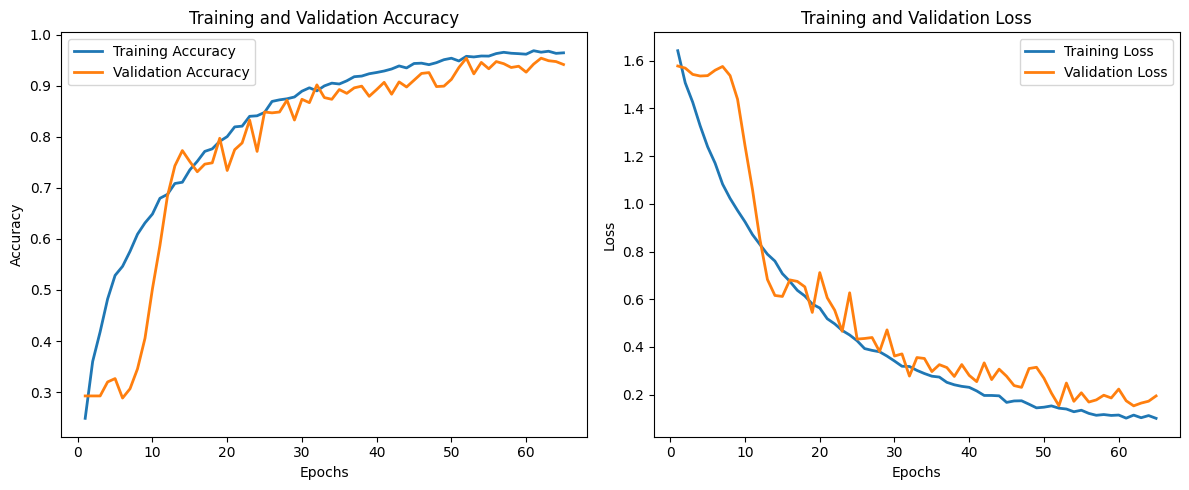

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


**USING FINE TUNING**

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), #With lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9729 - loss: 0.0980 - val_accuracy: 0.9410 - val_loss: 0.1840
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 788ms/step - accuracy: 0.9740 - loss: 0.0824 - val_accuracy: 0.9444 - val_loss: 0.1706
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 780ms/step - accuracy: 0.9722 - loss: 0.0982 - val_accuracy: 0.9468 - val_loss: 0.1645
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 775ms/step - accuracy: 0.9776 - loss: 0.0787 - val_accuracy: 0.9452 - val_loss: 0.1680
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 782ms/step - accuracy: 0.9677 - loss: 0.1037 - val_accuracy: 0.9493 - val_loss: 0.1596
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 776ms/step - accuracy: 0.9689 - loss: 0.0960 - val_accuracy: 0.9502 - val_loss: 0.1582
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 785ms/step - accuracy: 0.9732 - loss: 0.0895 - val_accuracy: 0.9485 - val_loss: 0.1613
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 777ms/step - accuracy: 0.9685 - loss: 0.0983 - val_accura

**TESTING**

Saving 108677.jpg to 108677.jpg
Saving 108683.jpg to 108683.jpg
Saving 108685.jpg to 108685.jpg


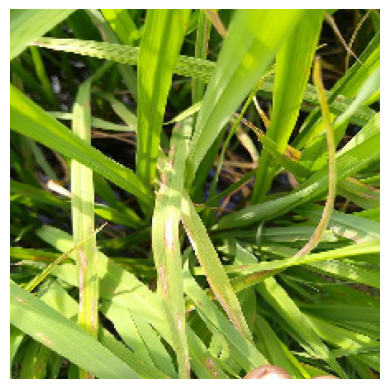

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 0.00%
brown_spot: 0.00%
normal: 0.00%
tungro: 100.00%

Result:
tungro: 100.00%


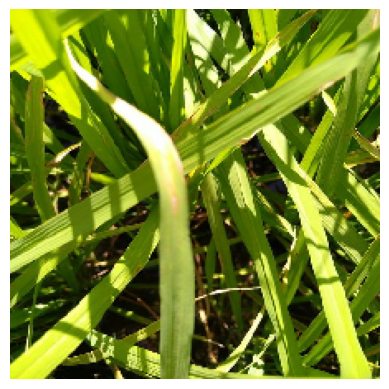

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 0.00%
brown_spot: 0.00%
normal: 100.00%
tungro: 0.00%

Result:
normal: 100.00%


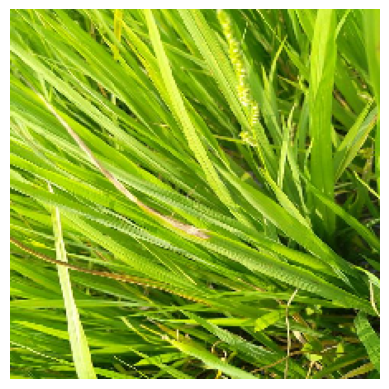

Prediction probabilities:
bacterial_leaf_blight: 0.00%
blast: 100.00%
brown_spot: 0.00%
normal: 0.00%
tungro: 0.00%

Result:
blast: 100.00%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for filepath in uploaded.keys():
    img = image.load_img(filepath, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    proba = model.predict(x, verbose=0)[0]

    print("Prediction probabilities:")
    for label, probability in zip(labels, proba):
        print(f"{label}: {probability * 100:.2f}%")

    max_index = np.argmax(proba)
    max_label = labels[max_index]
    max_proba = proba[max_index]

    print("\nResult:")
    if max_proba >= 0.5:
        print(f"{max_label}: {max_proba * 100:.2f}%")
    else:
        print("Hasil tidak ditemukan!")


**CONFUSSION MATRIX**

Found 1204 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


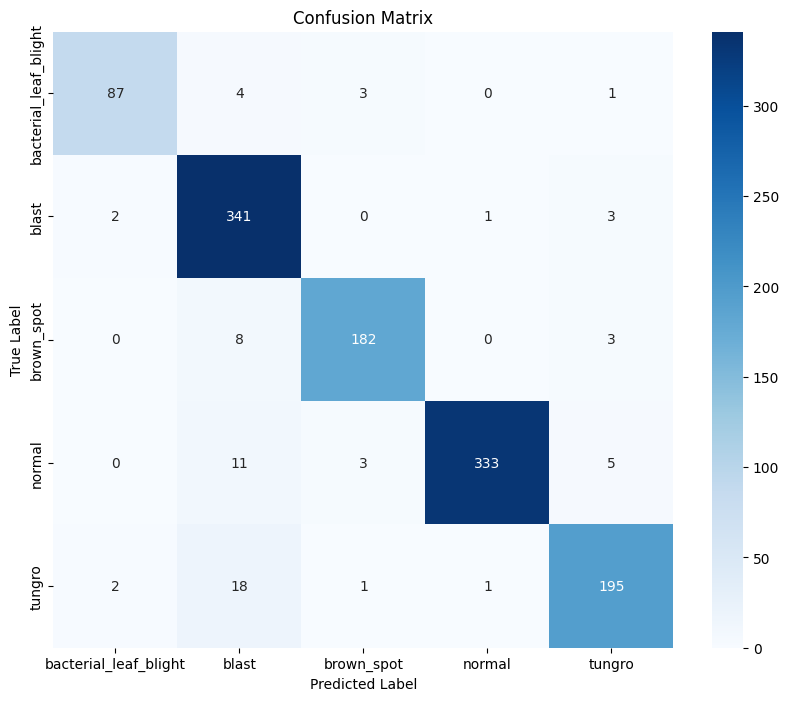

Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.96      0.92      0.94        95
                blast       0.89      0.98      0.94       347
           brown_spot       0.96      0.94      0.95       193
               normal       0.99      0.95      0.97       352
               tungro       0.94      0.90      0.92       217

             accuracy                           0.95      1204
            macro avg       0.95      0.94      0.94      1204
         weighted avg       0.95      0.95      0.95      1204



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))


**SAVE THE MODEL**

In [ ]:
model.save('model_padicare.h5')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model_padicare.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)